<a href="https://colab.research.google.com/github/kasiakry/MLBigDataset/blob/master/ml_2_big_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Success of Bank Telemarketing
## Project by Piotr Borowski & Katarzyna Kryńska

## Introduction




## Attribute Description

Input variables:
* bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
* related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
* social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/kasiakry/ml2-big-dataset/master/bank-additional-full.csv', sep=';')

In [111]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


## Cleaning the dataset

At first sight, it might seem that the dataset does not contain any missing values.

In [36]:
df.isna().values.any()

False

However, in case of nominal values, such as education or default, we can see that some rows contain 'unknown' value.

For nominal variables, there are a few ways of handling missing values:

1. Ignore observations with missing values - usually adequate when dataset is large and number of records with missing values is low and when missing data is not Missing not at Random (the most popular example is that people with high salaries generally do not want to reveal their income in surveys).
2. Ignore variable containing missing values - usually adequate if the variable is not significant.
3. Replace missing value with most frequent value - there is a risk that it will introduce bias.
4. Predict missing values - e.g. with multiclass predictor.
5. Treat missing data as another category.  

Firstly we will check which variables and how many rows contain 'unknown' value.

In [37]:
for col in df.columns.drop('y'):
    if df[col].dtype==object:
      percent_of_missing = df.loc[df[col]=='unknown',col].count() / len(df)
      if percent_of_missing > 0:
        print('Column', col, 'contains', '{:2.2%}'.format(percent_of_missing),'uknown values')

Column job contains 0.80% uknown values
Column marital contains 0.19% uknown values
Column education contains 4.20% uknown values
Column default contains 20.87% uknown values
Column housing contains 2.40% uknown values
Column loan contains 2.40% uknown values


We can see that variable *default* contains most missing data. We will plot a bar plot to check if this variable seems significant.

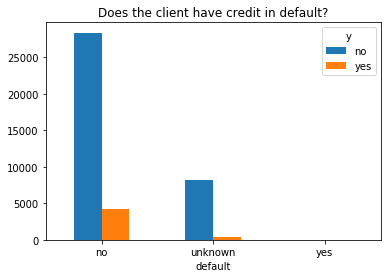

In [38]:
df.groupby('y')['default'].value_counts().unstack(0).plot.bar(rot=0, title='Does the client have credit in default?');

Bar plot suggests that it would be better to leave this variable as it is - with *uknown* values. We will also leave *uknown* values in other variables, with the exception of *marital* variable, as the number of missing data is very small - therefore we will use the most frequent value to replace missing values.

In [0]:
df['marital'] = df['marital'].replace('unknown', 'married')

### Duration

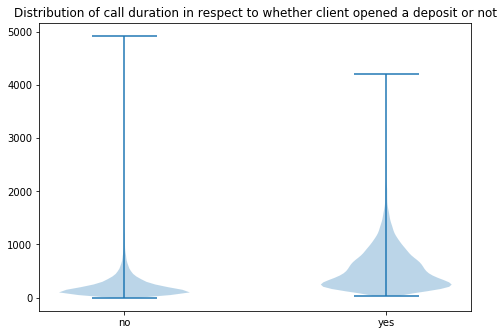

In [40]:
data_to_plot = [df.duration[df['y']=='no'].to_numpy(), df.duration[df['y']=='yes'].to_numpy()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(data_to_plot)
ax.set_xticks(np.arange(1, 3))
ax.set_xticklabels(['no', 'yes'])
ax.set_title('Distribution of call duration in respect to whether client opened a deposit or not')
plt.show()

Variable "duration" is the duration of last call with the client. Including this variable as it is in our model could lead to a huge data leakage - for example if duration = 0 then y='no'. There seem to be two possible ways of coping with the problem. 

First one would be deleting observations with duration below a threshold, e.g. 30 seconds. However, from a business perspective, this solution is not ideal. Our goal is to make marketing strategies more effective - meaning consuming less of our resources. Clients who do not pick up phone, still are taking up our time to make a call to them. Secondly, duration of the call is not known before making the call - and ideally we would like to know client's propensity to our campaign before making the call.

Therefore, our decision is to remove 'duration' variable from our dataset.

In [0]:
df = df.drop("duration", axis=1)

### Exploratory data analysis

Firstly, we will check the number of clients that subscribed to a term deposit vs the number of clients that did not. We can see that the dataset is moderately imbalanced - number of clients that subscribed to a term deposit equals to 11.27% of the whole dataset. This means that accuracy might be not the best metric to measure performance of our classification models and also that it might be wise to use some techniques to work with imbalanced datasets, such as oversampling, undersampling or generating synthetic samples. 

Campaign overall success rate:  11.27%


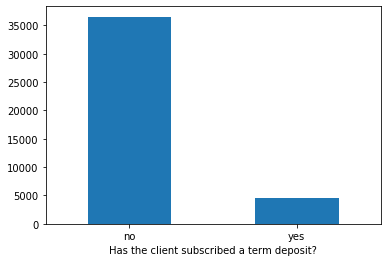

In [42]:
barplot = df['y'].value_counts().plot.bar(rot=0)
barplot.set_xlabel('Has the client subscribed a term deposit?');
print('Campaign overall success rate: ', '{:2.2%}'.format(len(df[df.y=='yes']) / len(df)))

Now we will look into distributions of numerical data in the dataset by plotting histograms. Firstly, we can see that in our dataset there is not many people in the age of 60+. Interestingly, we can divide our dataset in regard to Euribor rate into two groups - one with rate around 1% and the second one with rate from 4 to 5%. We can also notice that most of the dataset consists of clients who the company had not contacted before. 

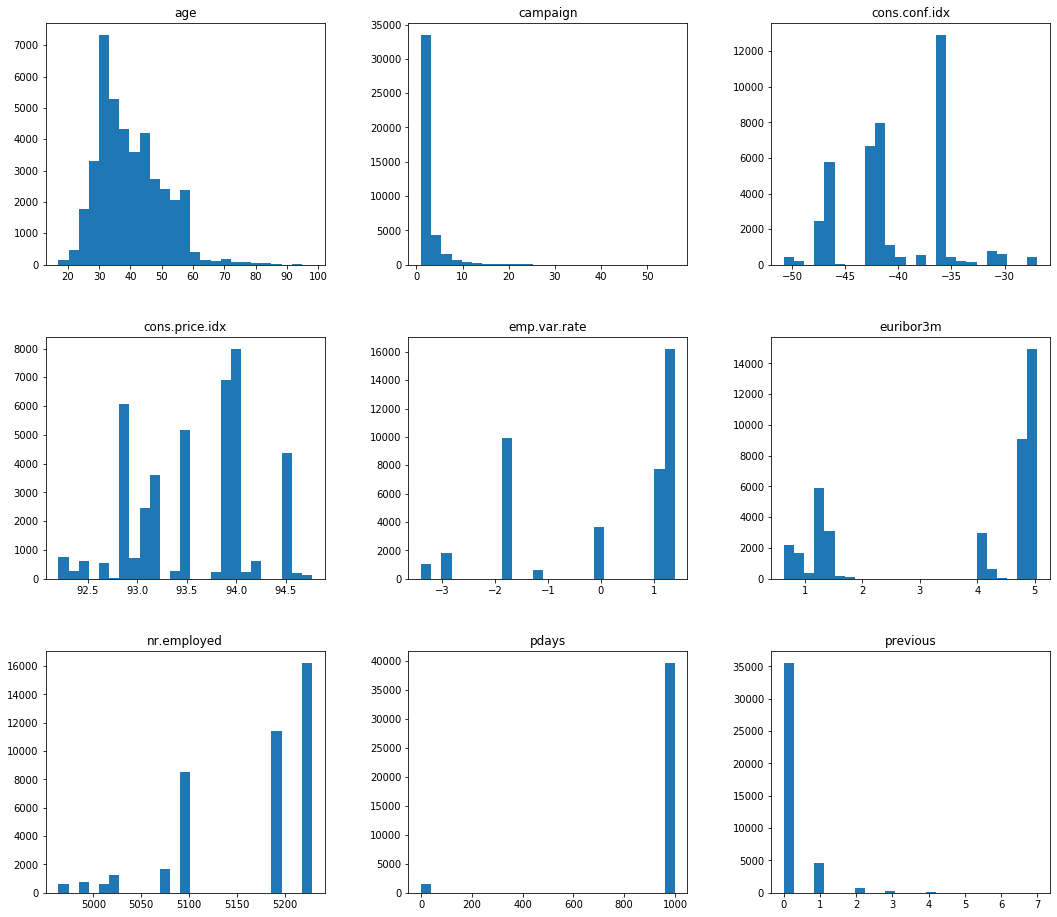

In [43]:
df.hist(figsize=(18,16), bins=25, grid=False);

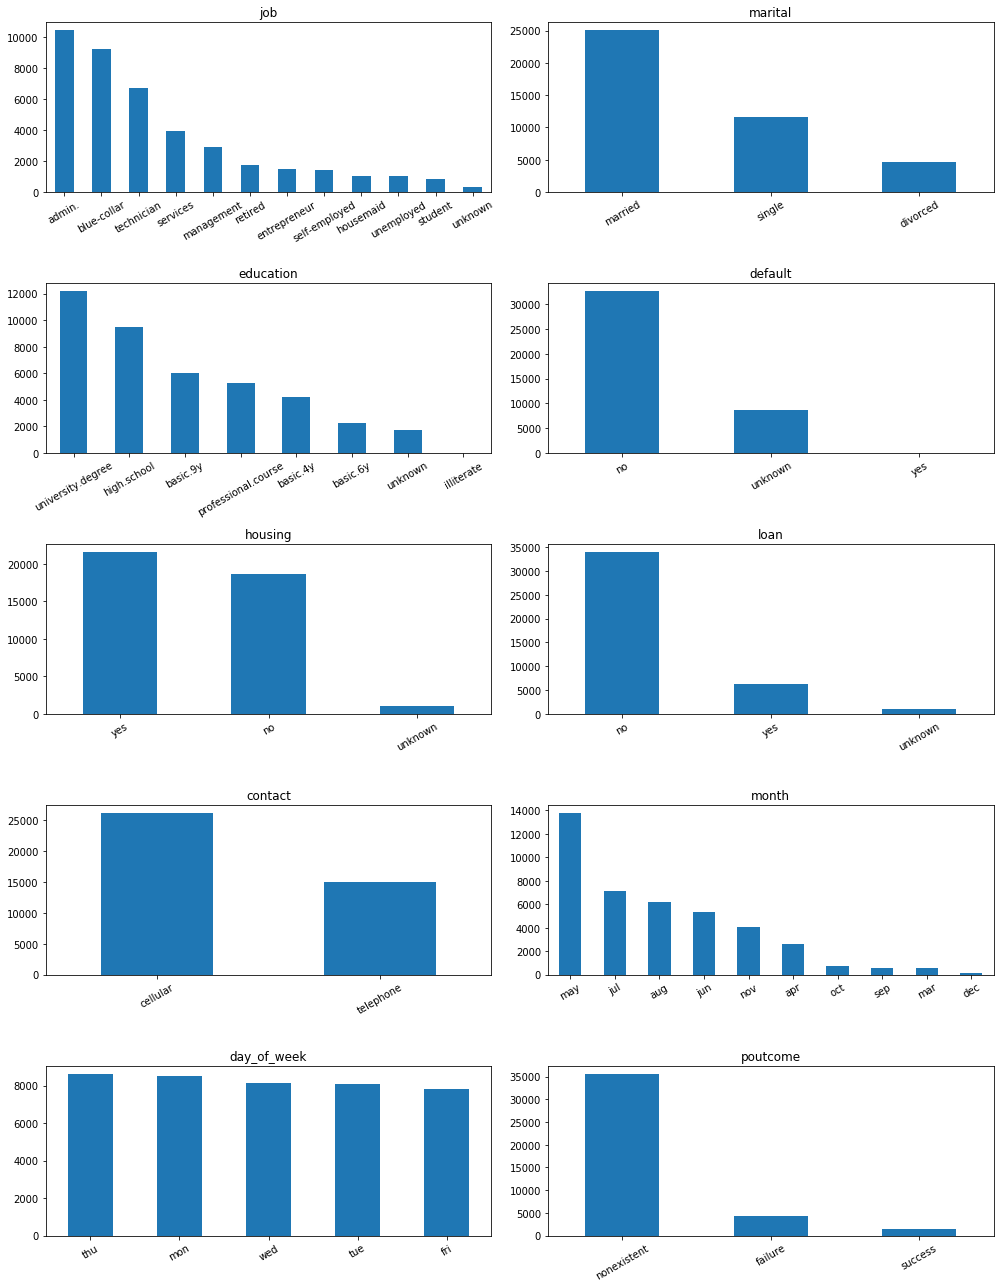

In [44]:
fig, axs = plt.subplots(5, 2)
i=0
for col in df.columns.drop('y'):
    if df[col].dtype==object:
        df[col].value_counts().plot.bar(rot=30, title=col, ax = axs[i//2,i%2])
        i=i+1
fig.set_size_inches(14, 18)
fig.tight_layout();

## Data preparation

Firstly, target variable needs to be recoded into binary form.

In [0]:
df["y"] = (df.y=="yes").astype(int)

Our dataset contains both continuous and discrete variables. Out of discrete variables, only one has potential to be treated as ordinal data - and that is education. However, due to 'uknown' values, we can not put all education categories in a particular order. Therefore, we will treat it as nominal variable. 

One Hot Encoding is known as "the classic approach" to dealing with nominal data. Accordingly, we will recode all variables with nominal levels to binary form.

In [0]:
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)
dummLev = pd.get_dummies(df[levCols])
df_ohc = pd.concat([df[numCols], dummLev], axis=1)

In [113]:
df_ohc.head(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
5,45,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
6,59,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
7,41,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
8,24,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
9,25,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


### Feature selection

#### Chi-Squared Feature Selection

In [0]:
numCols.remove('y')

# Seperate the features from the target variable and choose only categorical variables
y = df_ohc.y
X = df_ohc.drop('y', axis=1)
X_categorical = X.drop(numCols, axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.3, random_state=58)

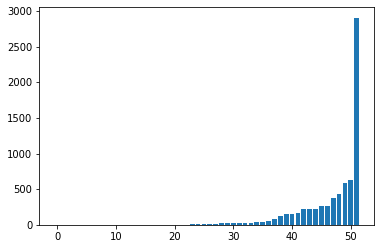

In [141]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# plot the scores
fs.scores_.sort()
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We decided to leave observations for which score is above 5.

In [146]:
count = sum(map(lambda x : x > 5, fs.scores_))
bestfeatures  = SelectKBest(score_func=chi2, k=count)
fit = bestfeatures.fit(X_train, y_train)
mask = bestfeatures.get_support()
cols_categorical = X_categorical.columns[mask]
print(cols_categorical)

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_retired',
       'job_services', 'job_student', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_mon', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


#### ANOVA F-value For Feature Selection

In [0]:
from sklearn.feature_selection import f_classif

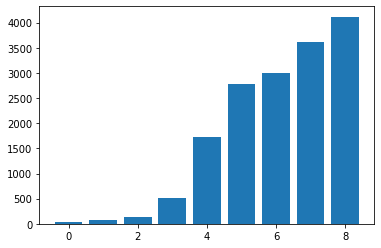

In [148]:
X_numerical = X[numCols]

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.3, random_state=58)

fs = SelectKBest(f_classif, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# plot the scores
fs.scores_.sort()
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


In [152]:
count = sum(map(lambda x : x > 200, fs.scores_))
bestfeatures  = SelectKBest(score_func=f_classif, k=count)
fit = bestfeatures.fit(X_train, y_train)
mask = bestfeatures.get_support()
cols_numerical = X_numerical.columns[mask]
print(cols_numerical)

Index(['pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')


In [169]:
df_feat = df_ohc[cols_numerical.to_list() + cols_categorical.to_list () + ['y']]
df_feat.head(5)

,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_retired,job_services,job_student,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_university.degree,education_unknown,default_no,default_unknown,contact_cellular,contact_telephone,month_apr,month_dec,month_jul,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
1,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
2,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
3,999,0,1.1,93.994,4.857,5191.0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
4,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0


## Logistic regression

Logistic regression is an excellent baseline algorithm and it can serve as a benchmark to our later models. Python library scikit-learn offers five different solvers algorithms - in our analysis we chose 'lbfgs', as it is usually faster for bigger datasets than 'liblinear' and it does not need scaling the features. We increased the maximum number of iterations to 1000, as the algorithm failed to converge with default 100 iterations. 

In [0]:
# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Train model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

# Predict on training dataset
y_train_pred_lr = log_reg.predict(X_train)

# Predict on testing dataset
y_pred_lr = log_reg.predict(X_test)

To see how well logistic regression did, we will plot a confusion matrix. To make a plot, we will use function provided by [wagnerbhbr](https://github.com/wcipriano/pretty-print-confusion-matrix).


In [0]:
#import sys, importlib
#importlib.reload(sys.modules['confusion_matrix_pretty_print'])
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
def plot_conf_m(y_train, y_train_pred, y_test, y_test_pred):
  fig, axs = plt.subplots(1, 2)
  plot_confusion_matrix_from_data(y_train, y_train_pred, figsize=[6,6], columns=['No','Yes'], pred_val_axis='y', ax1=axs[0], title='Training dataset')
  plot_confusion_matrix_from_data(y_test, y_test_pred, figsize=[6,6], columns=['No','Yes'], pred_val_axis='y', ax1=fig.axes[1], title='Testing dataset')
  fig.set_size_inches(12, 6)
  fig.tight_layout()
  fig.show();

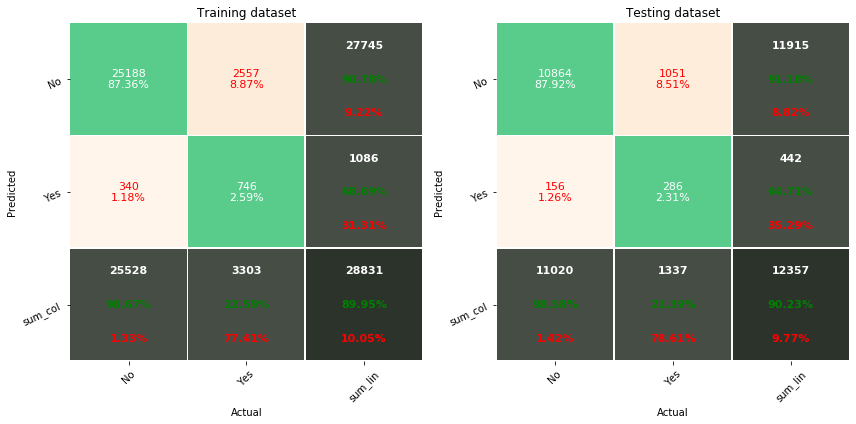

In [85]:
plot_conf_m(y_train, y_train_pred_lr,y_test, y_pred_lr)

In [86]:
# area under curve
roc_auc_score(y_test, y_pred_lr)

0.5998778314263724

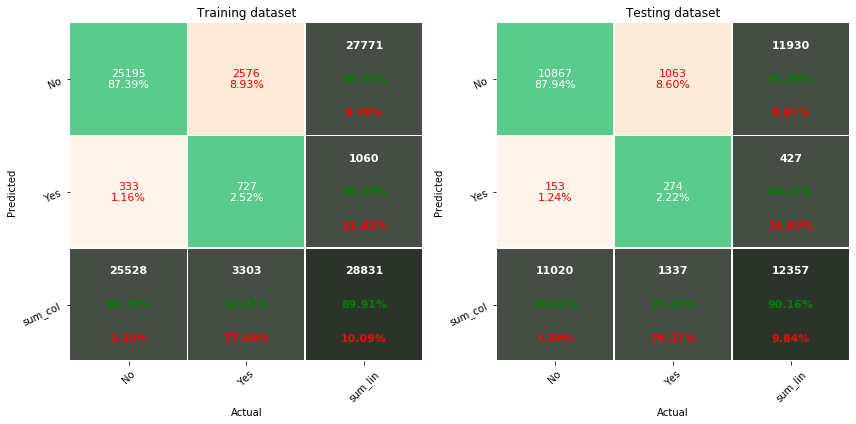

In [170]:
# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Train model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

# Predict on training dataset
y_train_pred_lr = log_reg.predict(X_train)

# Predict on testing dataset
y_pred_lr = log_reg.predict(X_test)

plot_conf_m(y_train, y_train_pred_lr,y_test, y_pred_lr)

## Decision tree

Decision trees are a non-parametric supervised learning method. They are simple to understand and interpret and, what more, they are easy to visualize. However, they are prone to overfitting - to avoid this problem we can use following solutions:
1. Pre-pruning by setting appropriate stopping criterion,
2. Post-pruning the large tree.

Python library scikit learn provides parameters *min_samples_leaf*, *max_depth* and *ccp_alpha* to prevent a tree from overfitting. To set adequate parameters, we will divide our training dataset into training and validation samples and apply best performing tree to our test data.


In [0]:
from sklearn.tree import DecisionTreeClassifier

In [174]:
# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Divide train dataset into training and validation subsets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=58)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=58)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


Number of nodes in the last tree is: 1 with ccp_alpha: 0.030137787434358493


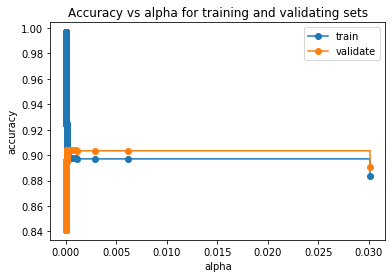

In [175]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
validate_scores = [clf.score(X_validate, y_validate) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validating sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, validate_scores, marker='o', label="validate",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [0]:
clf = DecisionTreeClassifier(random_state=58, ccp_alpha=0.005)

# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

clf.fit(X_train, y_train)

# Predict on training dataset
y_train_pred_dt = clf.predict(X_train)

# Predict on testing dataset
y_pred_dt = clf.predict(X_test)



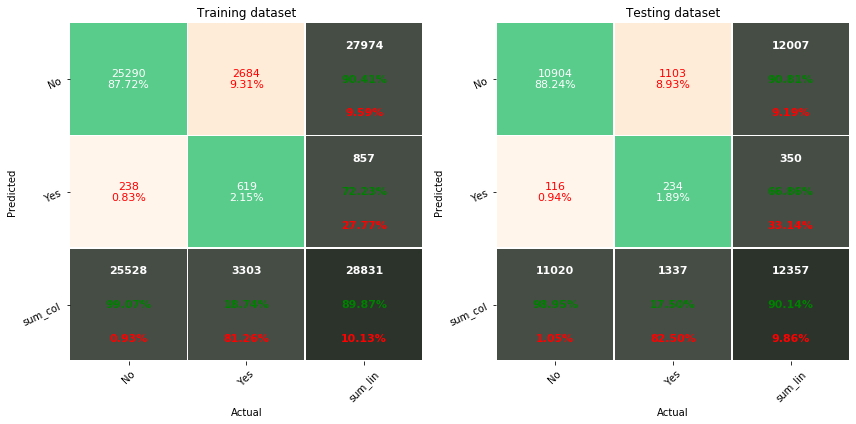

In [177]:
plot_conf_m(y_train, y_train_pred_dt,y_test, y_pred_dt)

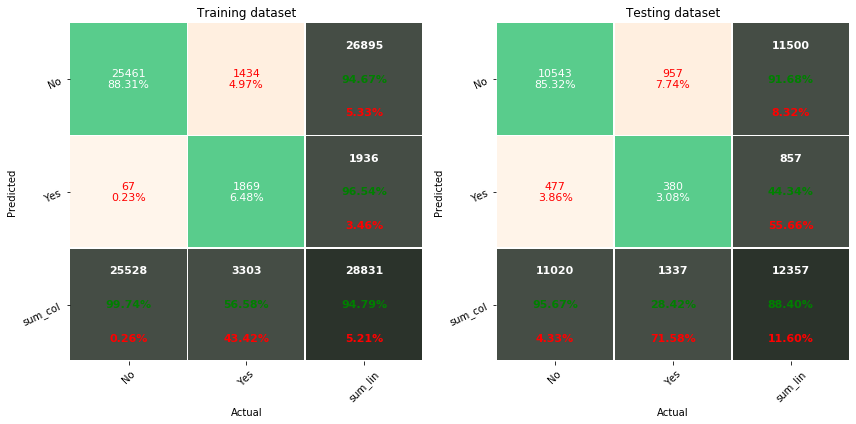

In [178]:
clf = DecisionTreeClassifier(random_state=58, ccp_alpha=0)

# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

clf.fit(X_train, y_train)

# Predict on training dataset
y_train_pred_dt = clf.predict(X_train)

# Predict on testing dataset
y_pred_dt = clf.predict(X_test)

plot_conf_m(y_train, y_train_pred_dt,y_test, y_pred_dt)

In [179]:
# Decision tree feature selected dataset

# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Divide train dataset into training and validation subsets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=58)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=58)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)

[ 0.00000000e+00 -5.42101086e-20 -2.71050543e-20 ...  2.25009289e-03
  6.16073985e-03  3.01377874e-02]


Number of nodes in the last tree is: 3 with ccp_alpha: 0.030137787434358493


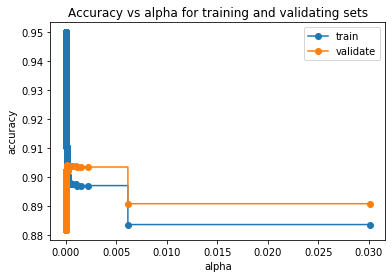

In [182]:
clfs = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha<0:
      ccp_alpha = 0
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

train_scores = [clf.score(X_train, y_train) for clf in clfs]
validate_scores = [clf.score(X_validate, y_validate) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validating sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, validate_scores, marker='o', label="validate",
        drawstyle="steps-post")
ax.legend()
plt.show()

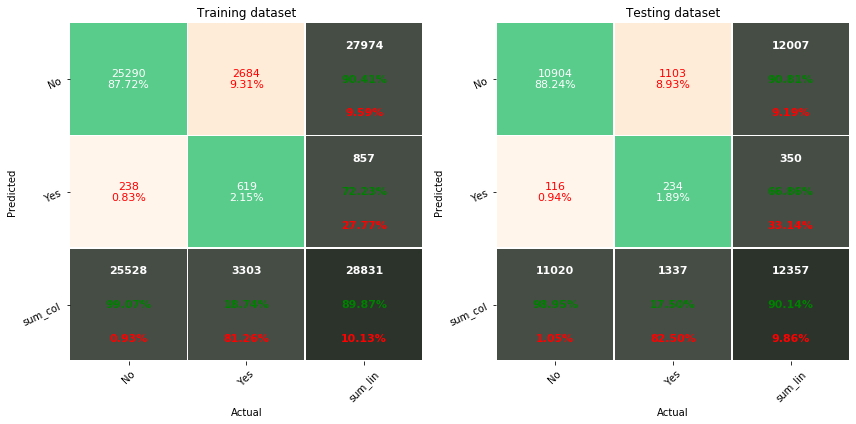

In [183]:
clf = DecisionTreeClassifier(random_state=58, ccp_alpha=0.005)

# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

clf.fit(X_train, y_train)

# Predict on training dataset
y_train_pred_dt = clf.predict(X_train)

# Predict on testing dataset
y_pred_dt = clf.predict(X_test)

plot_conf_m(y_train, y_train_pred_dt,y_test, y_pred_dt)

[Text(200.88000000000002, 181.2, 'X[5] <= 5087.65\ngini = 0.203\nsamples = 28831\nvalue = [25528, 3303]'),
 Text(133.92000000000002, 108.72, 'X[0] <= 15.5\ngini = 0.494\nsamples = 3480\nvalue = [1930, 1550]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.401\nsamples = 857\nvalue = [238, 619]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.458\nsamples = 2623\nvalue = [1692, 931]'),
 Text(267.84000000000003, 108.72, 'gini = 0.129\nsamples = 25351\nvalue = [23598, 1753]')]

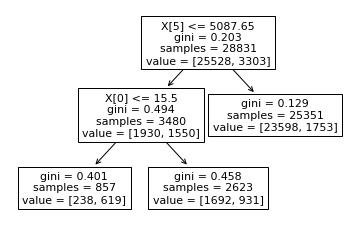

In [186]:
 from sklearn import tree
tree.plot_tree(clf.fit(X_train, y_train)) 

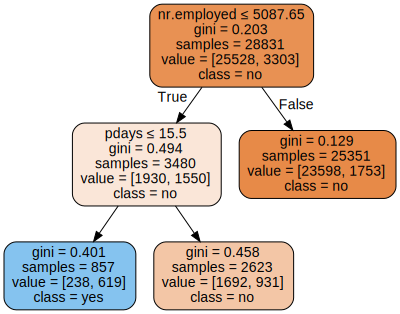

In [190]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns,
                                class_names=['no','yes'],
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data)
graph

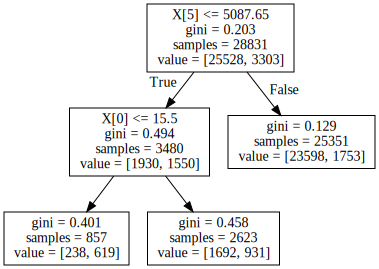

In [188]:
graph 